# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [2]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit, prange
import os   

In [4]:
with open(os.path.join(os.getcwd(), '../../scenario_properties-long.pkl'), 'rb') as f:
    scenario_properties = pickle.load(f)

In [26]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

# Convert to symbols
print(len(symbols)) # Should be 320 for a 40, 8 matrix
print(symbols)

#equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
#drag_flattened = [scenario_properties.full_drag[i, j] for j in range(scenario_properties.full_drag.cols) for i in range(scenario_properties.full_drag.rows)]
#pmd_flattened = [scenario_properties.full_Cdot_PMD[i, j] for j in range(scenario_properties.full_Cdot_PMD.cols) for i in range(scenario_properties.full_Cdot_PMD.rows)]
#collisions_flattened = [scenario_properties.full_coll[i, j] for j in range(scenario_properties.full_coll.cols) for i in range(scenario_properties.full_coll.rows)]

# Convert equations to lambda functions
#equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
#full_drag = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_flattened]
#full_pmd = [sp.lambdify(symbols, eq, 'numpy') for eq in pmd_flattened]
# full_coll = [sp.lambdify(symbols, eq, 'numpy') for eq in collisions_flattened]

600
[S_148kg_1, S_148kg_2, S_148kg_3, S_148kg_4, S_148kg_5, S_148kg_6, S_148kg_7, S_148kg_8, S_148kg_9, S_148kg_10, S_148kg_11, S_148kg_12, S_148kg_13, S_148kg_14, S_148kg_15, S_148kg_16, S_148kg_17, S_148kg_18, S_148kg_19, S_148kg_20, S_148kg_21, S_148kg_22, S_148kg_23, S_148kg_24, S_148kg_25, S_148kg_26, S_148kg_27, S_148kg_28, S_148kg_29, S_148kg_30, S_148kg_31, S_148kg_32, S_148kg_33, S_148kg_34, S_148kg_35, S_148kg_36, S_148kg_37, S_148kg_38, S_148kg_39, S_148kg_40, S_750kg_1, S_750kg_2, S_750kg_3, S_750kg_4, S_750kg_5, S_750kg_6, S_750kg_7, S_750kg_8, S_750kg_9, S_750kg_10, S_750kg_11, S_750kg_12, S_750kg_13, S_750kg_14, S_750kg_15, S_750kg_16, S_750kg_17, S_750kg_18, S_750kg_19, S_750kg_20, S_750kg_21, S_750kg_22, S_750kg_23, S_750kg_24, S_750kg_25, S_750kg_26, S_750kg_27, S_750kg_28, S_750kg_29, S_750kg_30, S_750kg_31, S_750kg_32, S_750kg_33, S_750kg_34, S_750kg_35, S_750kg_36, S_750kg_37, S_750kg_38, S_750kg_39, S_750kg_40, S_1250kg_1, S_1250kg_2, S_1250kg_3, S_1250kg_4, S_125

In [10]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

full_interp = []
for species_group in scenario_properties.species.values():
    for species in species_group:
        try:
            print(len(species.lambda_interp1d))
            full_interp.append(species.lambda_interp1d)

full_interp_flattened = []
for i in range(len(full_interp)):
    if full_interp[i] is not None:
        full_interp_flattened.extend(full_interp[i])
    else:
        full_interp_flattened.extend([None]*scenario_properties.n_shells)

IndentationError: unexpected unindent (2578963836.py, line 17)

In [5]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    print(t)
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)
    for i in range(len(N)):
        if full_lambda[i] is not None:
            increase = full_lambda[i](t)
        else:
            increase = 0

        # try:
        #     rate_change = equations[i](*N)
        # except Exception as e:
        #     rate_change = 0  # Handle the exception by setting no rate change

        dN_dt[i] += increase

        if np.isnan(dN_dt[i]) or np.isinf(dN_dt[i]):
            dN_dt[i] = 0  # Reset the derivative to zero if it's NaN/Inf

    return dN_dt

# def population_shell(t, N, full_lambda, equations):
#     print(t)
#     # Initialize the rate of change array
#     dN_dt = np.zeros_like(N)
#     for i in range(len(N)):
#         if full_lambda[i] is not None:
#             increase = full_lambda[i](t)
#         else:
#             increase = 0

#         try:
#             rate_change = equations[i](*N)
#         except Exception as e:
#             rate_change = 0  # Handle the exception by setting no rate change

#         dN_dt[i] += increase
#         dN_dt[i] += rate_change

#         if np.isnan(dN_dt[i]) or np.isinf(dN_dt[i]):
#             dN_dt[i] = 0  # Reset the derivative to zero if it's NaN/Inf

#     return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_interp_flattened, equations), 
                    t_eval=scenario_properties.scen_times, method='BDF')

NameError: name 'full_interp_flattened' is not defined

In [1]:
plt.figure(figsize=(10, 6))

# Assuming output.y has a shape of (n_variables, n_time_points)
# Loop over the first 40 variables (or species shells)
for i in range(351, 391):
    plt.plot(output.t, output.y[i], label=f'Species Shell {i+1}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Species 1 All Shells')
plt.xlim(0, 70)


plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


NameError: name 'plt' is not defined

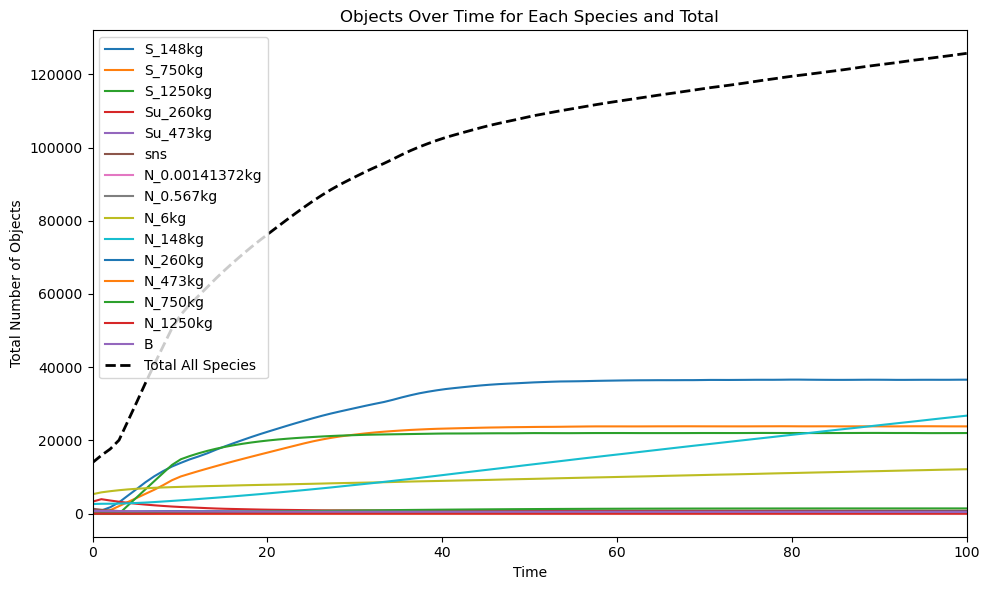

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names is available
species_names = scenario_properties.species_names

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
# Adjust the ylim based on the range of total_objects_all_species if necessary
# plt.ylim(0, np.max(total_objects_all_species) * 1.1)

plt.legend()
plt.tight_layout()
plt.show()


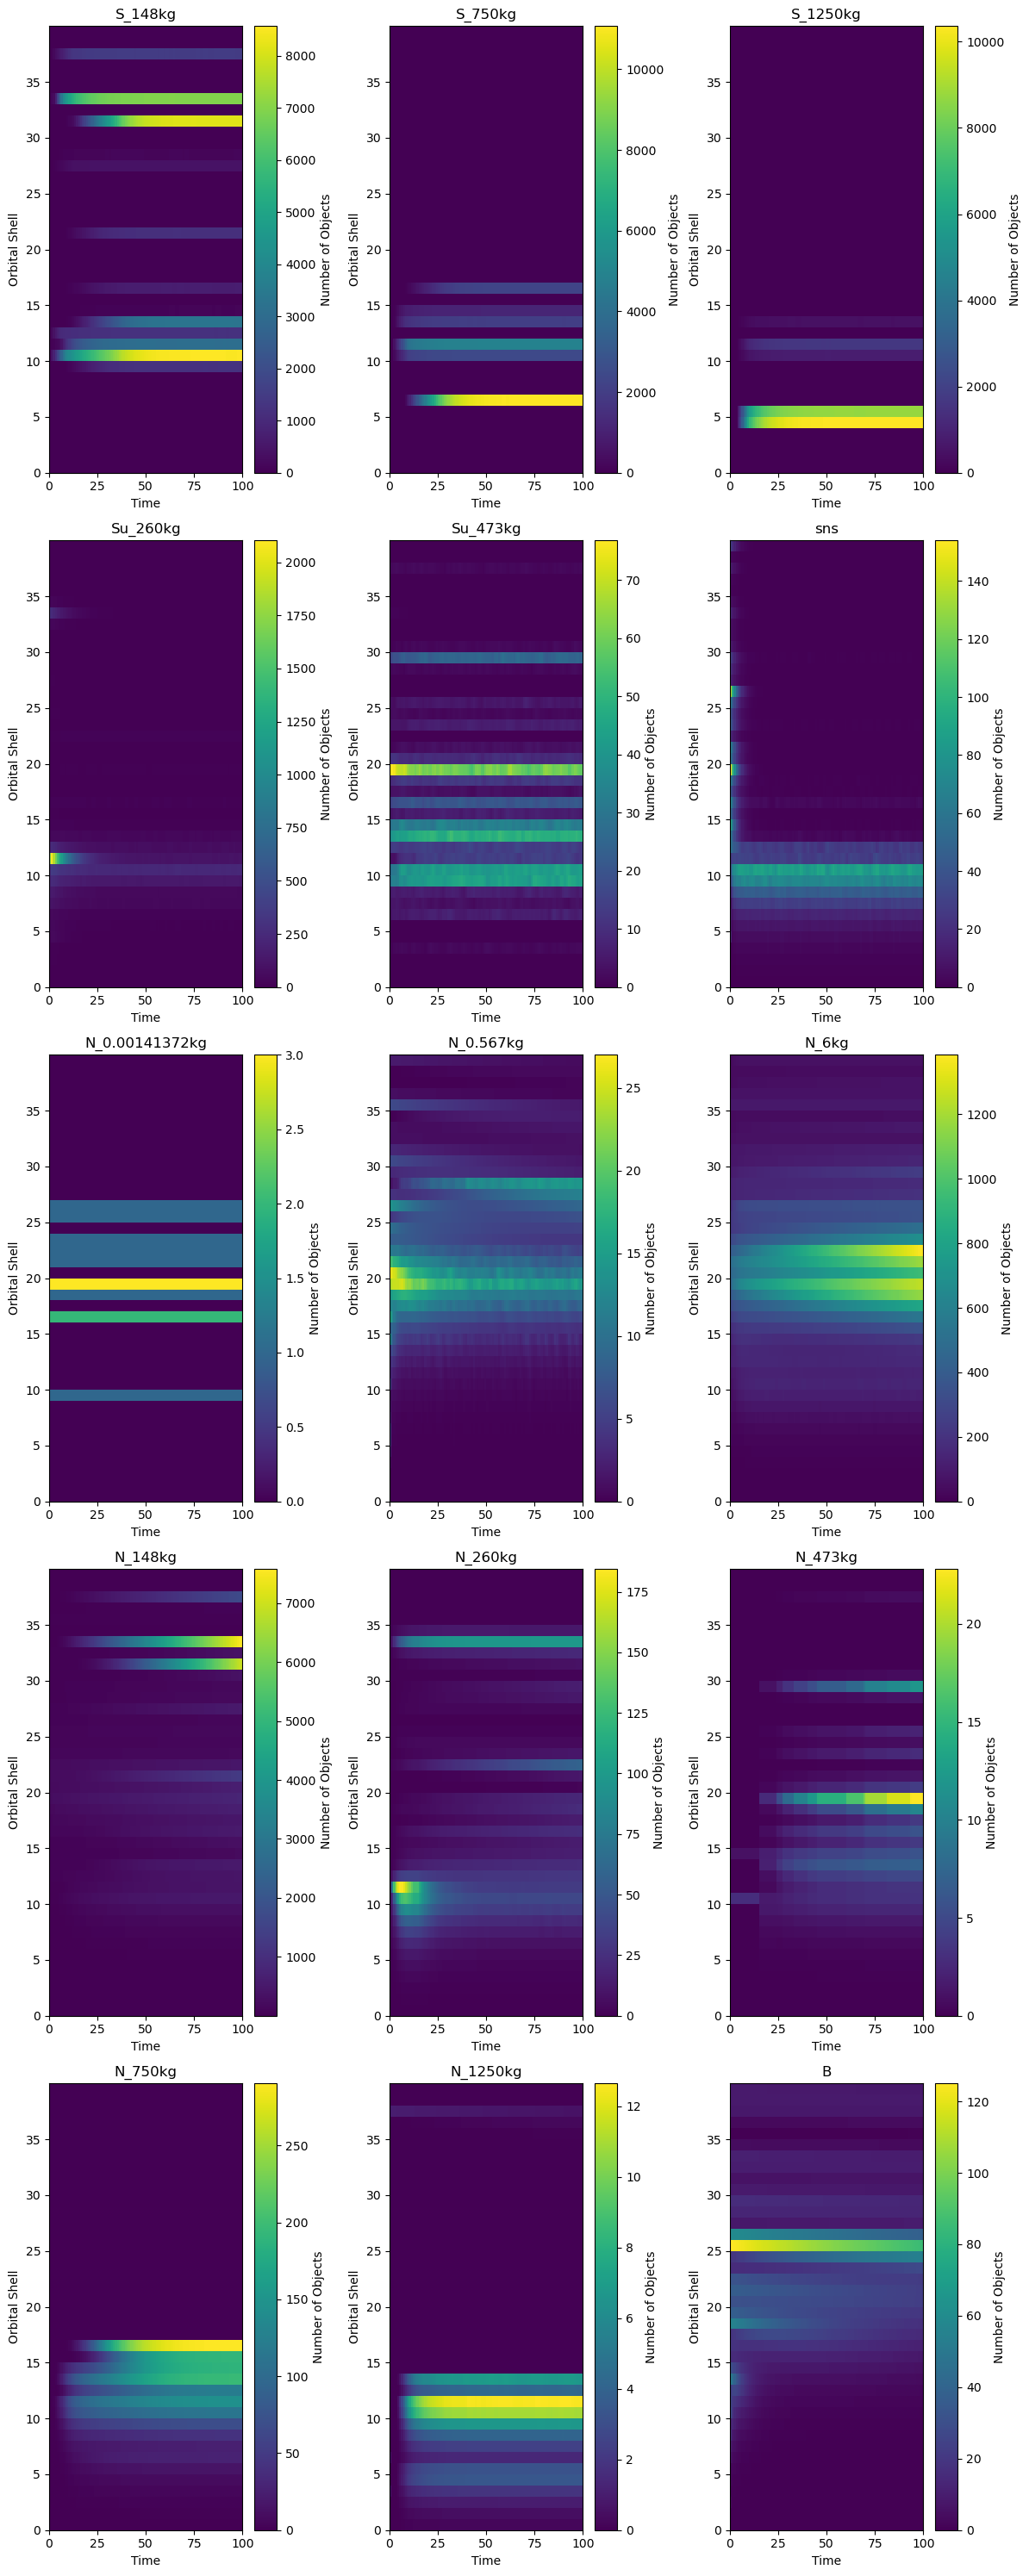

In [39]:
species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])

# Determine the grid size based on the number of species
cols = 3  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, rows * 6))

for i, species_name in enumerate(species_names):
    # Calculate the position in the grid
    row = i // cols
    col = i % cols
    if rows == 1:
        ax = axs[col]  # When there's only one row, `axs` is a 1D array
    else:
        ax = axs[row, col]

    # Extract the data for the current species across all shells
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    data_per_species = output["y"][start_idx:end_idx, :]
    
    # Plotting the heatmap
    cax = ax.imshow(data_per_species, aspect='auto', origin='lower',
                    extent=[output["t"][0], output["t"][-1], 0, num_shells],
                    interpolation='nearest')
    fig.colorbar(cax, ax=ax, label='Number of Objects')
    ax.set_xlabel('Time')
    ax.set_ylabel('Orbital Shell')
    ax.set_title(species_name)
    ax.set_xticks(np.linspace(output["t"][0], output["t"][-1], num=5))
    ax.set_yticks(np.arange(0, num_shells, 5))
    #ax.set_yticklabels([f'{alt:.0f}' for alt in scenario_properties.R0_km[::5]])

# Adjust layout and hide any unused axes
for i in range(num_species, rows*cols):
    if rows == 1:
        fig.delaxes(axs[i])
    else:
        axs.flatten()[i].set_visible(False)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


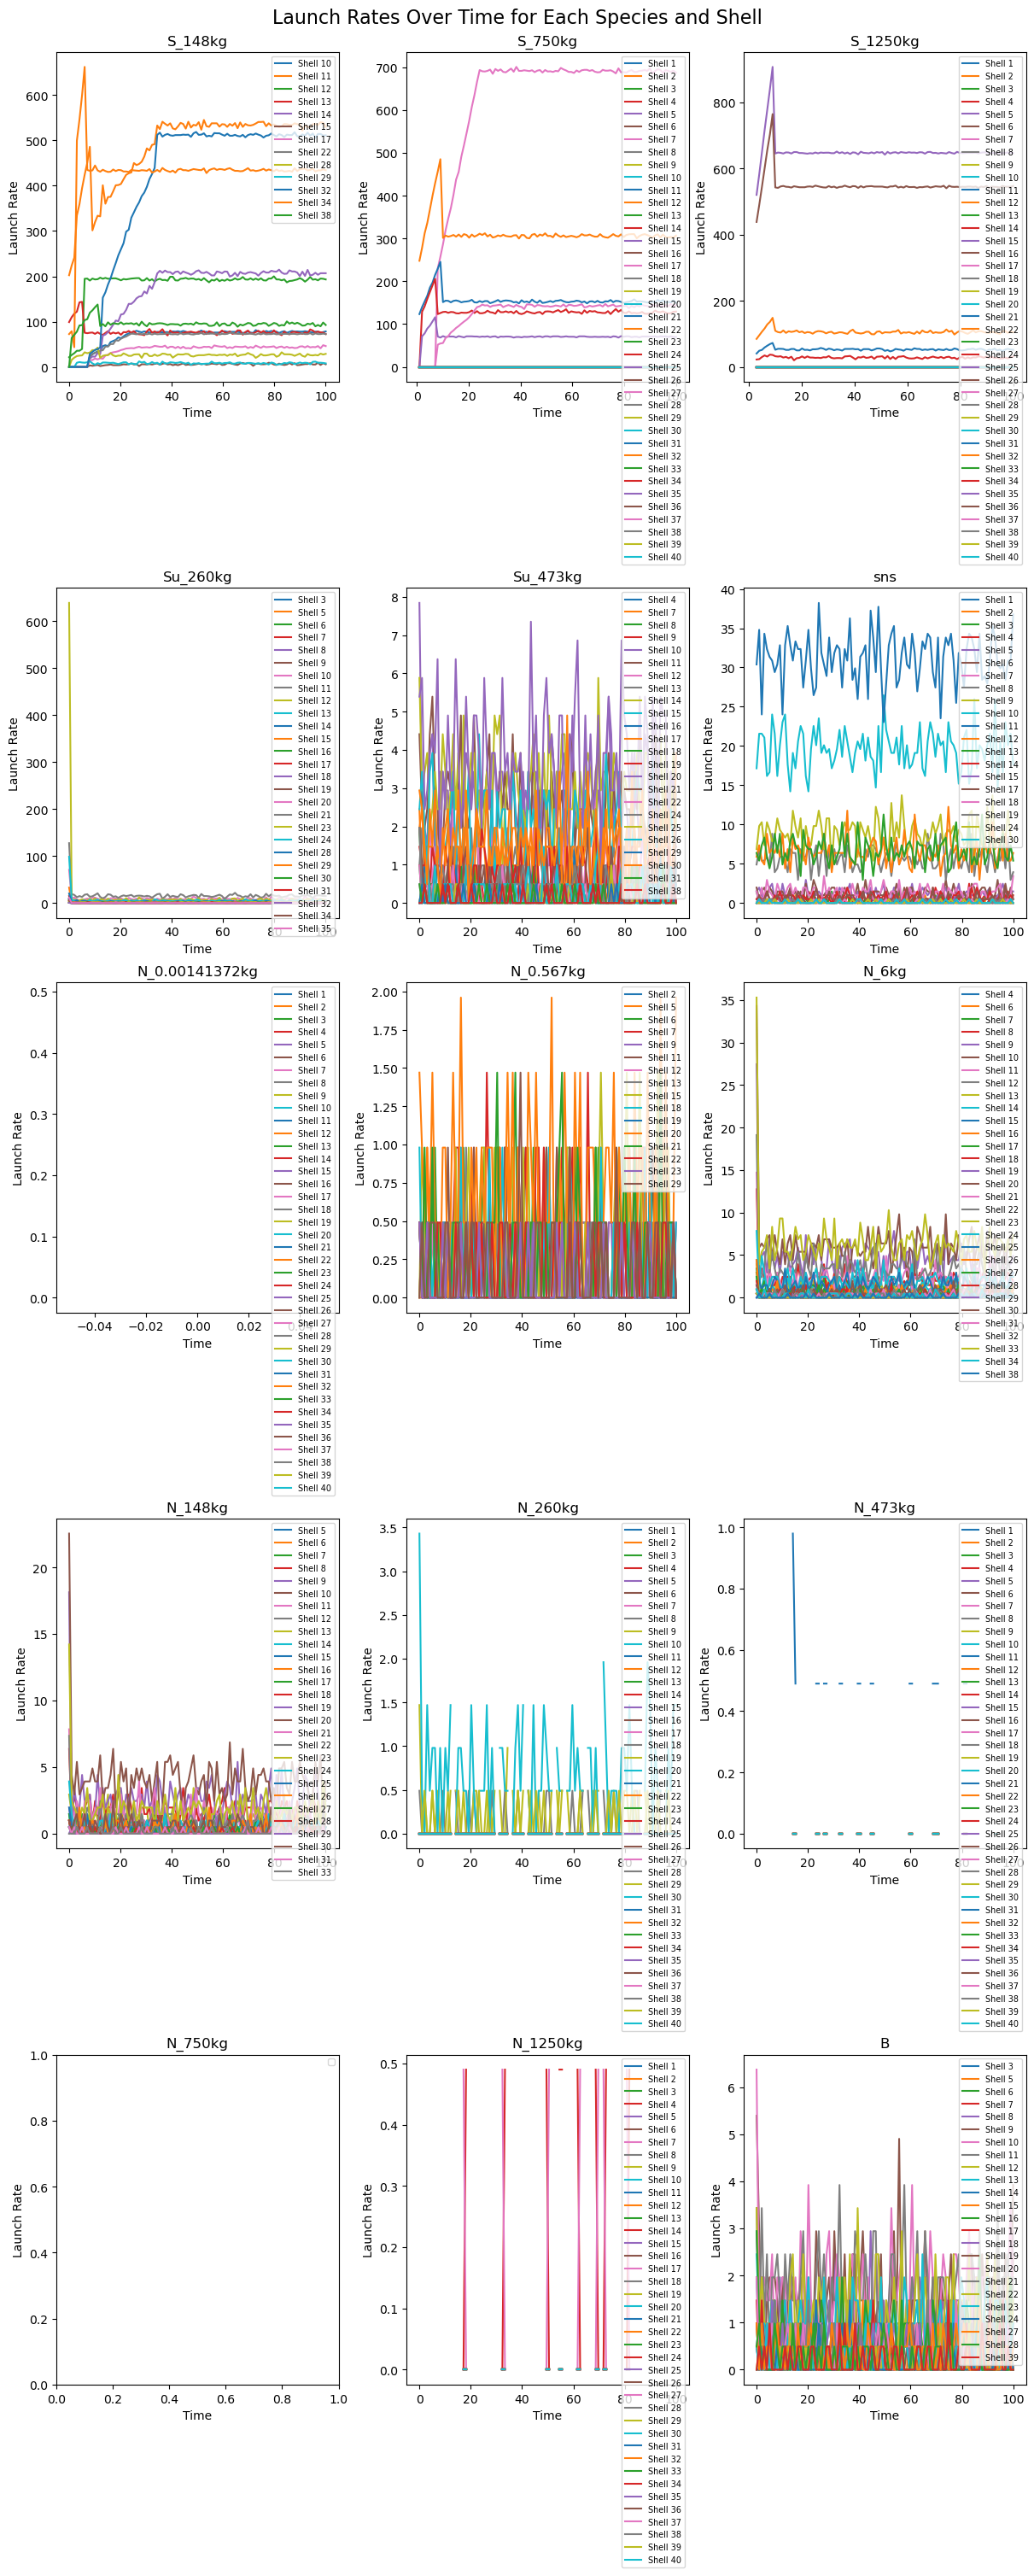

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names and scenario_properties.times are available
species_names = scenario_properties.species_names
times = scenario_properties.scen_times  # Time points for x-axis
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species

# Determine the grid size based on the number of species
cols = 3  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, rows * 6), constrained_layout=True)

# Iterate through each species and its corresponding data in full_lambda_flattened
for i in range(num_species):
    row = i // cols
    col = i % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    
    # Assume each species' data is split across num_shells consecutive arrays in full_lambda_flattened
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    
    for shell_index in range(start_idx, end_idx):
        if full_lambda_flattened[shell_index] is not None:
            # Interpolate data for plotting
            interpolated_data = np.interp(times, times, full_lambda_flattened[shell_index])
            interpolated_data = interpolated_data / 2
            ax.plot(times, interpolated_data, label=f'Shell {shell_index - start_idx + 1}')
    
    ax.set_title(species_names[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Launch Rate')
    ax.legend(loc='upper right', fontsize='x-small')

# Hide any unused axes
for j in range(num_species * num_shells, rows * cols):
    if rows > 1:
        axs.flatten()[j].set_visible(False)
    else:
        axs[j].set_visible(False)

plt.suptitle('Launch Rates Over Time for Each Species and Shell', fontsize=16)
plt.show()

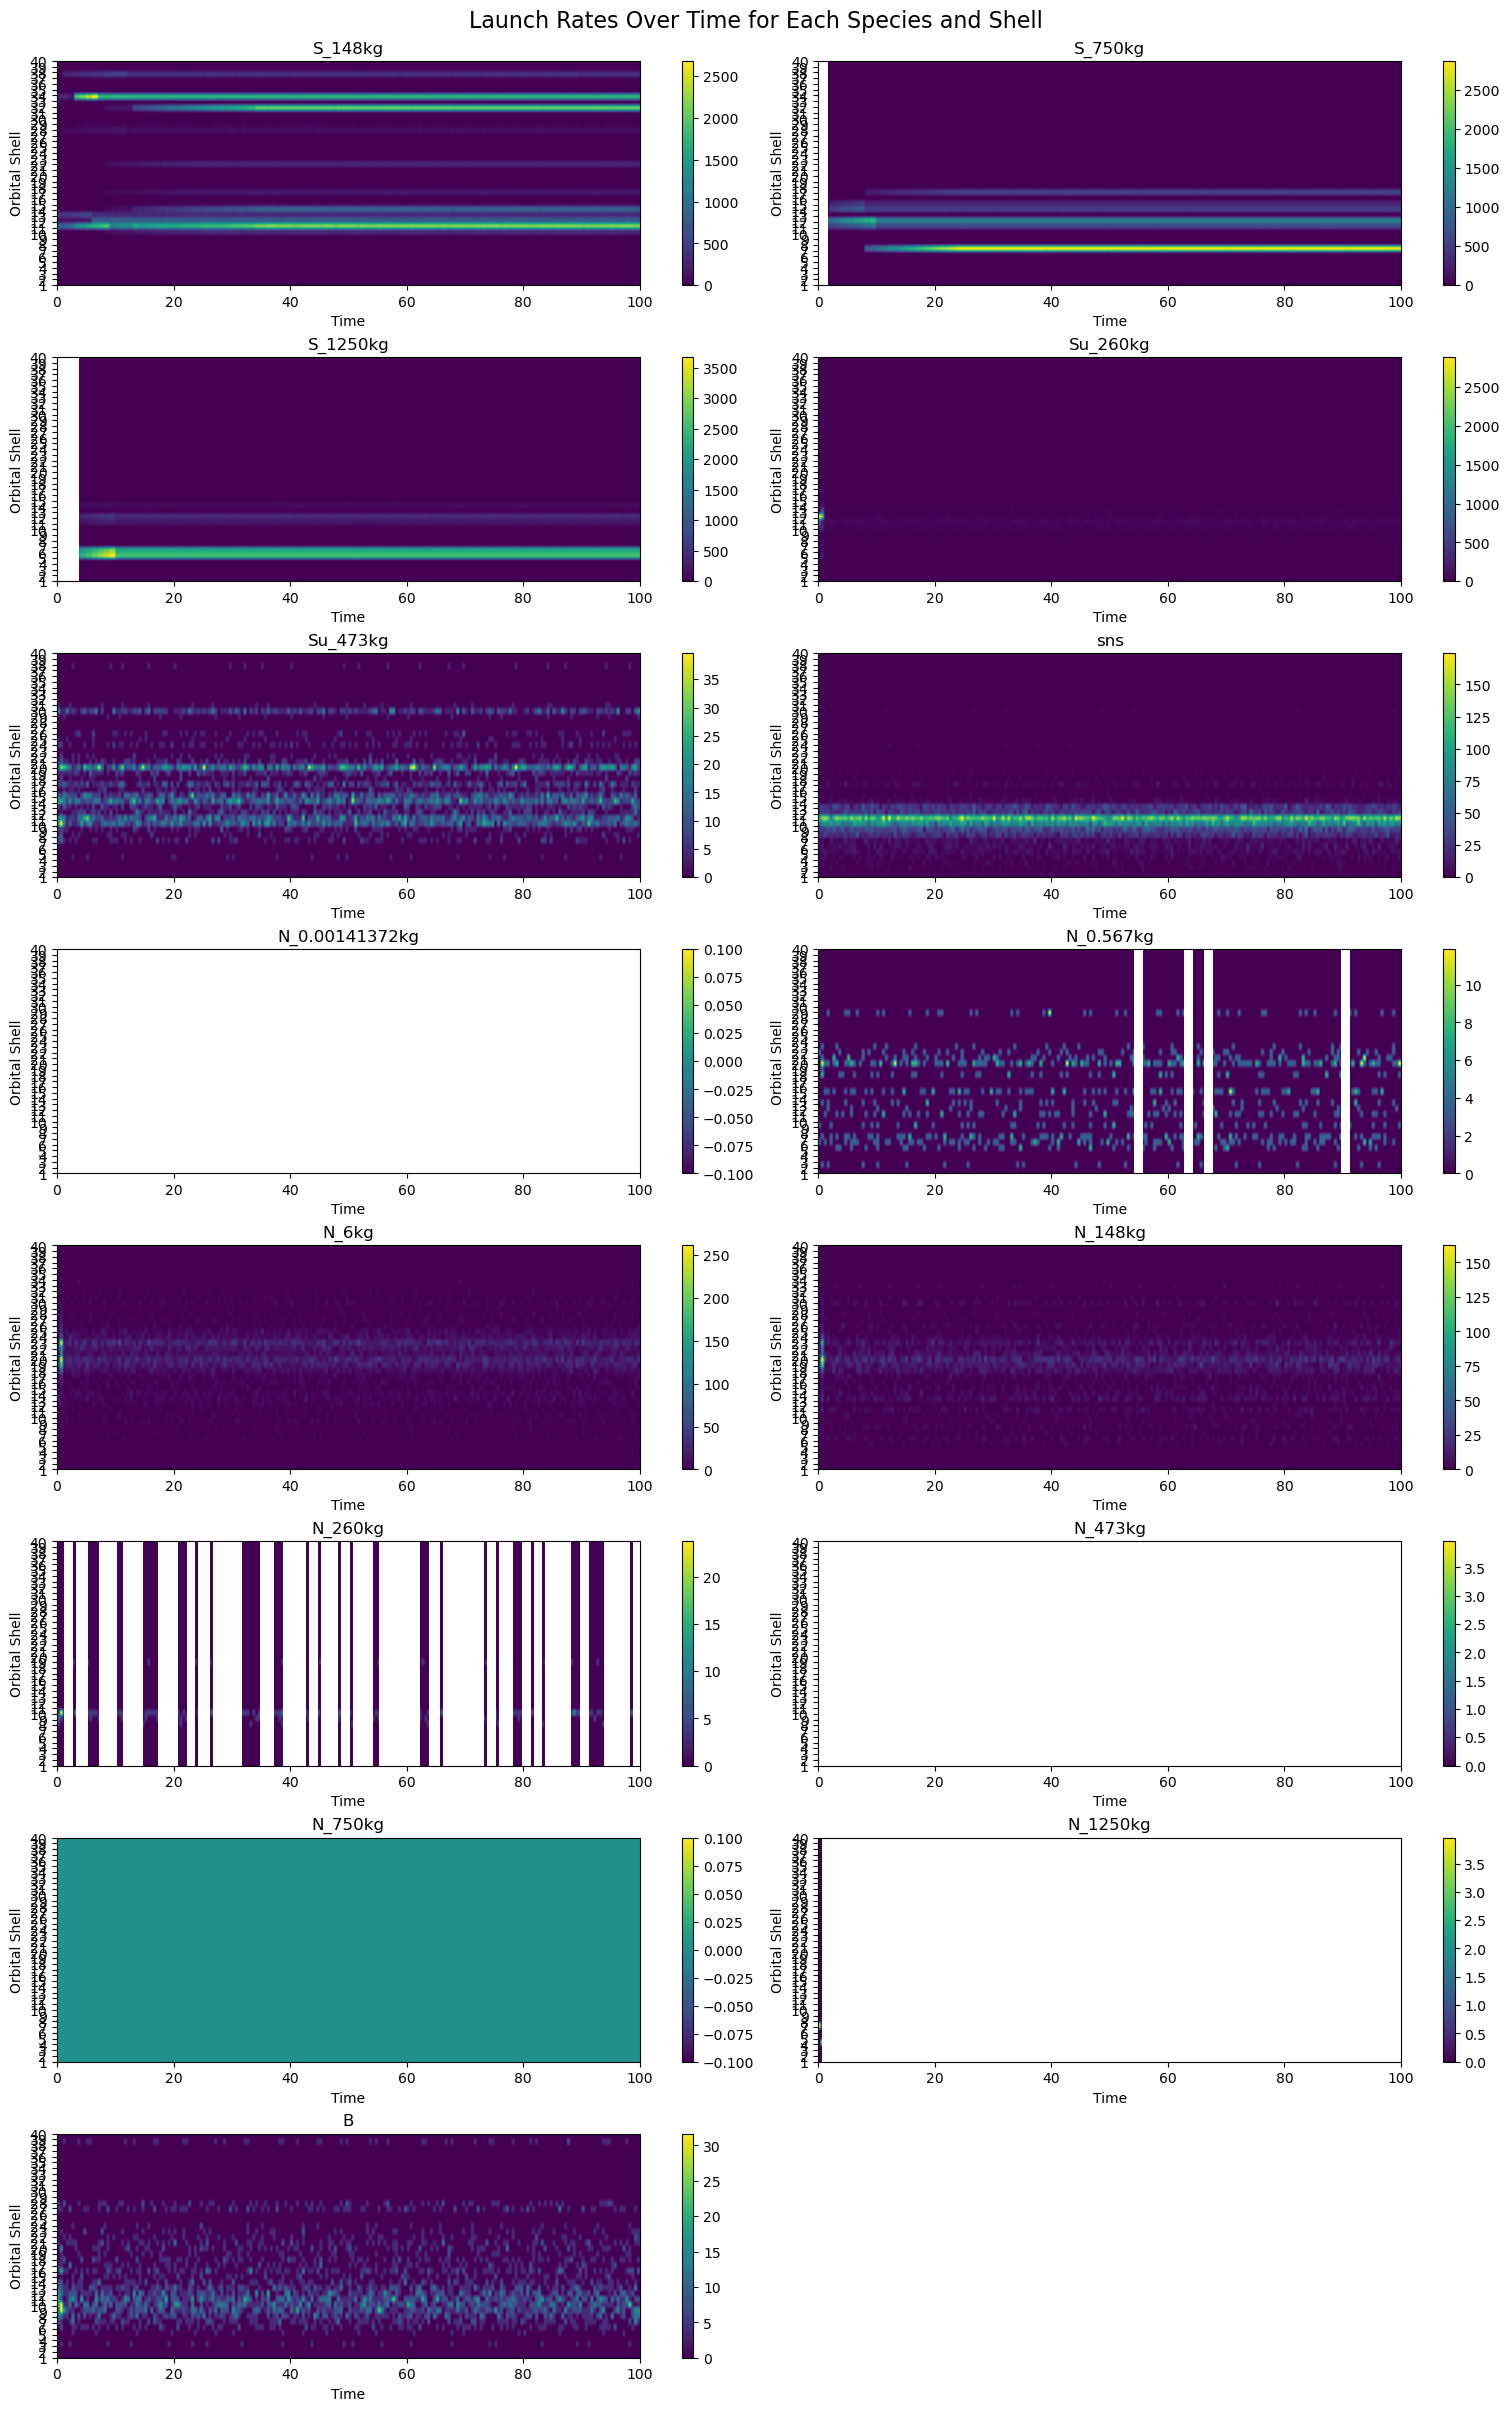

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names and scenario_properties.times are available
species_names = scenario_properties.species_names
times = scenario_properties.scen_times  # Time points for x-axis
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species

# Determine the grid size based on the number of species
cols = 2  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 3), constrained_layout=True)

for i, ax in enumerate(axs.flat):
    if i >= num_species:
        ax.set_visible(False)
        continue
    
    # Prepare an empty matrix to hold the interpolated data for all shells
    data_matrix = np.zeros((num_shells, len(times)))
    
    for shell_index in range(num_shells):
        index_in_lambda = i * num_shells + shell_index
        if full_lambda_flattened[index_in_lambda] is not None:
            # Call the interp1d function and fill the corresponding row in the data matrix
            data_matrix[shell_index, :] = full_lambda_flattened[index_in_lambda](times)
    
    # Plotting the heatmap for this species
    cax = ax.imshow(data_matrix, aspect='auto', cmap='viridis', origin='lower', extent=[times[0], times[-1], 1, num_shells])
    fig.colorbar(cax, ax=ax)
    
    ax.set_title(species_names[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Orbital Shell')
    ax.set_yticks(range(1, num_shells + 1))

plt.suptitle('Launch Rates Over Time for Each Species and Shell', fontsize=16)
plt.show()

## Drag Visualisation

In [136]:
for i in scenario_properties.full_lambda:
    # if i is not None
    if i:
        print(len(i))
    else:
        print('No')

40
40
40
40
40
40
40
40
40
40
40
40
No
40
40


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])

# Create the directory if it doesn't exist
directory = 'plots/drag/'
os.makedirs(directory, exist_ok=True)

def update_hist(num, data, ax, species_name):
    ax.clear()
    ax.bar(range(1, num_shells + 1), data[:, num], color='b')
    ax.set_title(f'{species_name} - Time: {output["t"][num]:.2f}')
    ax.set_xlabel('Orbital Shell')
    ax.set_ylabel('Number of Objects')
    ax.set_ylim(0, np.max(data))  # Adjust y-axis to fit all data
    ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

for i, species_name in enumerate(species_names):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract data for the current species across all shells and all time points
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    data_per_species = output["y"][start_idx:end_idx, :]
    
    # Create the animation
    ani = FuncAnimation(fig, update_hist, frames=n_time_points, fargs=(data_per_species, ax, species_name), repeat=False)

    # Save the animation as a GIF in the specified directory
    gif_path = os.path.join(directory, f'{species_name}_distribution.gif')
    ani.save(gif_path, writer='pillow', fps=10)  # Adjust fps as needed

    plt.close(fig)  # Close the plot to prevent display

### All in same plot

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])
shell_ids = scenario_properties.HMid  # Assuming this contains the identifiers for each shell

# Ensure that the length of HmID matches num_shells
if len(shell_ids) != num_shells:
    raise ValueError("The length of HmID does not match the number of shells")

# Determine the grid size based on the number of species
cols = 3  # You can adjust the number of columns based on your preference
rows = np.ceil(num_species / cols).astype(int)

# Create the directory if it doesn't exist
directory = 'plots/drag/'
os.makedirs(directory, exist_ok=True)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4), tight_layout=True)

def update_hist(num):
    # This function updates all subplots in each frame
    for i in range(num_species):
        ax = axs.flatten()[i]
        ax.clear()
        start_idx = i * num_shells
        end_idx = start_idx + num_shells
        ax.bar(shell_ids, output["y"][start_idx:end_idx, num], color='b')
        ax.set_title(f'{species_names[i]} - Time: {output["t"][num]:.2f}')
        ax.set_xlabel('Orbital Shell ID')
        ax.set_ylabel('Number of Objects')
        # Set y lim to fit just this species
        ax.set_ylim(0, np.max(output["y"][start_idx:end_idx, :]))
        #ax.set_ylim(0, np.max(output["y"]))  
        ax.grid(True)

    # Hide any unused axes
    for j in range(num_species, rows * cols):
        axs.flatten()[j].set_visible(False)

# Create the animation
ani = FuncAnimation(fig, update_hist, frames=n_time_points, repeat=False)

# Save the animation as a GIF in the specified directory
gif_path = os.path.join(directory, 'all_species_distribution.gif')
ani.save(gif_path, writer='pillow', fps=5)  # Adjust fps as needed

plt.close(fig)  # Close the plot to prevent display

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

species_names = ['S_148kg', 'S_750kg', 'S_1250kg', 'Su_260kg', 'Su_473kg', 'sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_148kg', 'N_260kg', 'N_473kg', 'N_750kg', 'N_1250kg', 'B']
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])
shell_ids = scenario_properties.HMid  # Assuming this contains the identifiers for each shell

# Categorize species into satellites and debris
satellite_species = [name for name in species_names if name[0].lower() == 's']
debris_species = [name for name in species_names if name[0].lower() != 's']

# Function to create directory and animation
def create_animation(species_list, category):
    directory = f'plots/drag/{category}/'
    os.makedirs(directory, exist_ok=True)
    
    for species_name in species_list:
        i = species_names.index(species_name)
        fig, ax = plt.subplots(figsize=(10, 6))
        data_per_species = output["y"][i * num_shells: (i + 1) * num_shells, :]

        def update_hist(num):
            ax.clear()
            ax.bar(shell_ids, data_per_species[:, num], color='b')
            ax.set_title(f'{species_name} - Time: {output["t"][num]:.2f}')
            ax.set_xlabel('Orbital Shell ID')
            ax.set_ylabel('Number of Objects')
            #ax.set_ylim(0, np.max(output["y"]))  # Set the y-limit to max of all data
            ax.grid(True)

        # Create the animation
        ani = FuncAnimation(fig, update_hist, frames=n_time_points, repeat=False)

        # Save the animation as a GIF in the specified directory
        gif_path = os.path.join(directory, f'{species_name}_distribution.gif')
        ani.save(gif_path, writer='pillow', fps=5)  # Adjust fps as needed

        plt.close(fig)  # Close the plot to prevent display

# Create animations for each category
create_animation(satellite_species, 'satellites')
create_animation(debris_species, 'debris')

### Collisions